# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 102.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import optuna
import shutil
import glob
import json
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e6/train.csv"
    test_path = "/kaggle/input/playground-series-s5e6/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e6/sample_submission.csv"

    original_path = "/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv"
    
    target = "Fertilizer Name"
    n_folds = 5
    seed = 42

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")
original = pd.read_csv(CFG.original_path)

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != CFG.target]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")
original[cat_cols] = original[cat_cols].astype(str).astype("category")

label_encoder = LabelEncoder()
train[CFG.target] = label_encoder.fit_transform(train[CFG.target])
original[CFG.target] = label_encoder.transform(original[CFG.target])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = original[CFG.target]

In [5]:
mutual_info = mutual_info_classif(X, y, random_state=CFG.seed, discrete_features=True)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Moisture,0.003308
Phosphorous,0.002984
Nitrogen,0.002373
Crop Type,0.002088
Potassium,0.001367
Humidity,0.001015
Temparature,0.000966
Soil Type,0.000617


In [6]:
mutual_info = mutual_info_classif(X_original, y_original, random_state=CFG.seed, discrete_features=True)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_original.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Phosphorous,0.001362
Moisture,0.001355
Nitrogen,0.001068
Potassium,0.000626
Humidity,0.000494
Temparature,0.000432
Crop Type,0.000320
Soil Type,0.000107


# Training base models

In [7]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [8]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if X_original is not None and y_original is not None:
                X_train = pd.concat([X_train, X_original])
                y_train = pd.concat([y_train, y_original])
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if fit_args:
                print(f"\n--- Fold {fold_idx + 1} - MAP@3: {score:.6f}\n\n")
            else:
                print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
            
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):        
        scores = []        
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

In [9]:
lgbm_params = {
    "boosting_type": "gbdt",
    "device": "gpu",
    "colsample_bytree": 0.4366677273946288,
    "learning_rate": 0.016164161953515117,
    "max_depth": 12,
    "min_child_samples": 67,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 243,
    "random_state": 42,
    "reg_alpha": 6.38288560443373,
    "reg_lambda": 9.392999314379155,
    "subsample": 0.7989164499431718,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "device": "gpu",
    "colsample_bytree": 0.32751831793031183,
    "learning_rate": 0.006700715059604966,
    "max_depth": 12,
    "min_child_samples": 84,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 229,
    "random_state": 42,
    "reg_alpha": 6.879977008084246,
    "reg_lambda": 4.739518466581721,
    "subsample": 0.5411572049978781,
    "verbose": -1
}

xgb_params = {
    # https://www.kaggle.com/code/patrykszcz/simple-xgb-model-5-fold
    "device": "gpu",
    "max_depth": 12,
    "colsample_bytree": 0.467,
    "subsample": 0.86,
    "n_estimators": 10000,
    "learning_rate": 0.03,
    "gamma": 0.26,
    "max_delta_step": 4,
    "reg_alpha": 2.7,
    "reg_lambda": 1.4,
    "early_stopping_rounds": 100,
    "objective": 'multi:softprob',
    "random_state": 13,
    "enable_categorical": True,
}

In [10]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

## LightGBM (gbdt)

In [11]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (gbdt)"], test_pred_probs["LightGBM (gbdt)"], scores["LightGBM (gbdt)"] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original, fit_args)

Training LGBMClassifier



1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.90104
[2000]	valid_0's multi_logloss: 1.89538
[3000]	valid_0's multi_logloss: 1.8944
Early stopping, best iteration is:
[3074]	valid_0's multi_logloss: 1.89439

--- Fold 1 - MAP@3: 0.361453


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.90035
[2000]	valid_0's multi_logloss: 1.89414
[3000]	valid_0's multi_logloss: 1.8931
Early stopping, best iteration is:
[3460]	valid_0's multi_logloss: 1.89305

--- Fold 2 - MAP@3: 0.362426


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.89961
[2000]	valid_0's multi_logloss: 1.89343
[3000]	valid_0's multi_logloss: 1.89232
Early stopping, best iteration is:
[2962]	valid_0's multi_logloss: 1.89231

--- Fold 3 - MAP@3: 0.364040


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.90131
[2000]	valid_0's multi_logloss: 1

## LightGBM (goss)

In [12]:
lgb_goss_model = LGBMClassifier(**lgbm_goss_params)
lgb_goss_trainer = Trainer(lgb_goss_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], scores["LightGBM (goss)"] = lgb_goss_trainer.fit_predict(X, y, X_test, X_original, y_original, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91083
[2000]	valid_0's multi_logloss: 1.90135
[3000]	valid_0's multi_logloss: 1.89721
[4000]	valid_0's multi_logloss: 1.89584
Early stopping, best iteration is:
[4183]	valid_0's multi_logloss: 1.89575

--- Fold 1 - MAP@3: 0.359902


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91055
[2000]	valid_0's multi_logloss: 1.90051
[3000]	valid_0's multi_logloss: 1.89609
[4000]	valid_0's multi_logloss: 1.8943
Early stopping, best iteration is:
[4634]	valid_0's multi_logloss: 1.89405

--- Fold 2 - MAP@3: 0.360952


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.90992
[2000]	valid_0's multi_logloss: 1.89992
[3000]	valid_0's multi_logloss: 1.89542
[4000]	valid_0's multi_logloss: 1.89356
Early stopping, best iteration is:
[4473]	valid_0's multi_logloss: 1.8932

--- Fold 3 - MAP@3: 0

## XGBoost

In [13]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)

fit_args = {
    "verbose": 1000
}

oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original, fit_args)

Training XGBClassifier

[0]	validation_0-mlogloss:1.94561
[1000]	validation_0-mlogloss:1.89243
[1613]	validation_0-mlogloss:1.89131

--- Fold 1 - MAP@3: 0.364166


[0]	validation_0-mlogloss:1.94561
[1000]	validation_0-mlogloss:1.89137
[1677]	validation_0-mlogloss:1.88990

--- Fold 2 - MAP@3: 0.364966


[0]	validation_0-mlogloss:1.94560
[1000]	validation_0-mlogloss:1.89034
[1775]	validation_0-mlogloss:1.88870

--- Fold 3 - MAP@3: 0.367839


[0]	validation_0-mlogloss:1.94559
[1000]	validation_0-mlogloss:1.89243
[1617]	validation_0-mlogloss:1.89133

--- Fold 4 - MAP@3: 0.365098


[0]	validation_0-mlogloss:1.94560
[1000]	validation_0-mlogloss:1.89158
[1618]	validation_0-mlogloss:1.89007

--- Fold 5 - MAP@3: 0.366344



------ Overall MAP@3: 0.365682 | Average MAP@3: 0.365682 ± 0.001284


## AutoGluon

In [14]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e06-fertilizer-optimization-autogluon/*_oof_pred_probs_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e06-fertilizer-optimization-autogluon/*_test_pred_probs_*.pkl')

ag_oof_preds = joblib.load(oof_preds_files[0])
ag_test_preds = joblib.load(test_preds_files[0])

ag_scores = []
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]
    score = map3(y_val, y_preds)
    ag_scores.append(score)
    
oof_pred_probs["AutoGluon"], test_pred_probs["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

# Ensembling with LogisticRegression

In [15]:
X = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

In [16]:
joblib.dump(X, "oof_pred_probs.pkl")
joblib.dump(X_test, "test_pred_probs.pkl")

['test_pred_probs.pkl']

In [17]:
lr_model = LogisticRegression(random_state=42, max_iter=500)

lr_trainer = Trainer(lr_model)
_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.364536
--- Fold 2 - MAP@3: 0.366253
--- Fold 3 - MAP@3: 0.368082
--- Fold 4 - MAP@3: 0.365700
--- Fold 5 - MAP@3: 0.366031

------ Overall MAP@3: 0.366120 | Average MAP@3: 0.366120 ± 0.001146


In [18]:
final_predictions = []
for i in np.argsort(lr_test_pred_probs)[:, -3:][:, ::-1]:
    prediction = label_encoder.inverse_transform(i)
    final_predictions.append(" ".join(prediction))

In [19]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = final_predictions
sub.to_csv(f"sub_logistic-regression_{np.mean(scores['LogisticRegression']):.6f}.csv", index=False)
sub.head()

,id,Fertilizer Name
0,750000,10-26-26 20-20 DAP
1,750001,17-17-17 10-26-26 20-20
2,750002,20-20 28-28 Urea
3,750003,14-35-14 DAP 17-17-17
4,750004,20-20 Urea 10-26-26


# Results

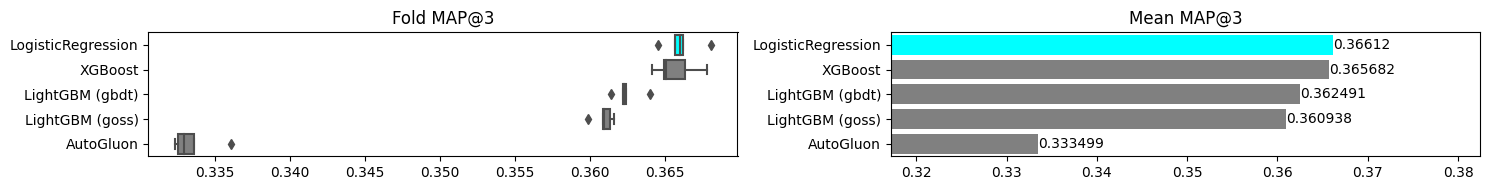

In [20]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [21]:
shutil.rmtree("catboost_info", ignore_errors=True)